In [1]:
import pandas as pd
from gensim import corpora, models, similarities, downloader
from collections import defaultdict
from pprint import pprint
import gensim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from skopt import dummy_minimize, gp_minimize, forest_minimize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score

import re
import os
import numpy as np
import pandas as pd
from pprint import pprint
import string
import scipy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
from unidecode import unidecode
# spacy for lemmatization
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import tokenize
from string import punctuation

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models.ldamulticore import LdaMulticore
import tqdm

import webbrowser

import ipywidgets as widgets
import random



import warnings
warnings.filterwarnings("ignore")

In [25]:
path = './data/04_feat_eng_df/'

# Nome dos arquivos dentro do diretorio acima (raw_df)
filenames = os.listdir(path)
# print(filenames[-2:])
# Dataframe dos dados sem tratamento
df = pd.read_csv(path + filenames[-1], sep='|').sort_values('list_id') # -1 para pegar o ultimo dataframe rf
desc = df[['desc_full', 'list_id']] # Series com a descricao de cada ap para o tfidf
df = df.drop('desc_full', axis=1) # Dataframe modificado


df_olx = pd.read_csv(path + filenames[-2], sep='|').sort_values('list_id') # -2 para pegar o penultimo dataframe lda

In [3]:
def nlp_trat(dataset):
    """ Funçao para a criacao da matriz esparça do tfidf"""
    
    tfidf = TfidfVectorizer(lowercase=True, max_features=50, min_df=2, ngram_range=(1, 2))
    token_espaco = tokenize.WhitespaceTokenizer()
    palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
    
    stemmer = nltk.RSLPStemmer()
    token_pontuacao = tokenize.WordPunctTokenizer()
    
    # Criação de lista com pontuação
    pontuacao = list()
    for ponto in punctuation:
        pontuacao.append(ponto)
    pontuacao
    
    # Criação de lista complementar de palavras para remover do dataset (justificativas no notebook de storytelling)
    compl_stop_words = ['dormitorio','sao','paulo','apartamento','apto','sp','r$','m2','alugar','aluga','dormitorios',
                        'aluguel','locacao','para','com','em','por','mes','r', 'codigo', 'anuncio']
    
    # Lista final de palavras e caracteres para serem removiodos
    pontuacao_stop_words = pontuacao + palavras_irrelevantes + compl_stop_words
    frase_processada = list()
    nova_frase = list()
    

    
    for desc in dataset:
        palavras_texto = token_pontuacao.tokenize(desc)
        for palavra in palavras_texto:
            if palavra not in pontuacao_stop_words and palavra.isalpha():
                nova_frase.append(stemmer.stem(palavra))
        frase_processada.append(' '.join(nova_frase))
    frase_final = frase_processada
    
# TFIDF
    tfidf_bruto = tfidf.fit_transform(frase_final)
    
    return tfidf_bruto

In [4]:
def tuning_rf(params):
    """ Função para tunar (otimização bayesiana) o modelo do random forest"""
    bootstrap = params[0]
    max_depth = params[1]
    max_features = params[2] 
    min_samples_leaf = params[3] 
    min_samples_split = params[4]
    n_estimators = params[5]
    
    model = RandomForestClassifier(bootstrap=bootstrap, max_depth=max_depth, max_features=max_features,
                          min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators)
    
    model.fit(X, y)
    y_pred = model.predict_proba(X)[: ,1]  # y_pred entre treino e teste
      
    return -average_precision_score(y, y_pred)

space_rf = [[True, False],
            [1, 2, 5, 10, None],
            ['auto', 'sqrt'], 
            (1, 4), 
            (2, 10),
            (500, 1000)]
##################################################################################################################

def tuning_lr(params):
    """ Função para tunar (otimização bayesiana) o modelo logistic regression """
    solver = params[0]
    penalty = params[1]
    C = params[2]
    
    model = LogisticRegression(solver=solver, penalty=penalty, C=C)
    
    model.fit(X, y)
    y_pred = model.predict_proba(X)[: ,1]  # y_pred entre treino e teste
    
    return -average_precision_score(y, y_pred)


space_lr = [['newton-cg', 'lbfgs', 'liblinear'],
            ['l2'],
            (0.01, 100)]

""" TFIDF """

tfidf = TfidfVectorizer(lowercase=True, max_features=50, min_df=2, ngram_range=(1, 2))

In [5]:
stoplist = set([])

texts = [[word.lower() for word in document.split() if word.lower() not in stoplist] for document in df_olx['DESC_3']]

frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1
texts = [[token for token in text if frequency[token] > 1]
         for text in texts]
dictionary = corpora.Dictionary(texts)

In [6]:
#Corpus são todas as palavras da base de dados 

corpus = [dictionary.doc2bow(text) for text in texts]


In [7]:
lsi = models.LsiModel(corpus, id2word=dictionary, num_topics=4) 
# Foi escolhido 4 topicos por conta do coeficiente de corencia ser mais elevado nessa quantidade de topicos

# BEM VINDO AO PEGA AP

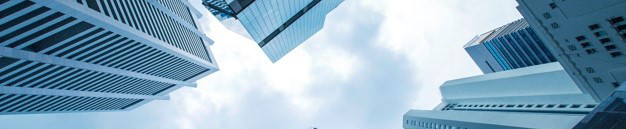

In [23]:
from PIL import Image
os.getcwd( )
im_p = Image.open('./img/predios2.jpg')
display(im_p)

In [9]:
doc = 'area_de_servico, portaria, elevador, condominio_fechado, 40.0_area, 1_banheiro, Consolação'

In [10]:
import ipywidgets as widgets
import random

vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi[vec_bow]
index = similarities.MatrixSimilarity(lsi[corpus])
sims = index[vec_lsi]
#sims = sorted(enumerate(sims), key=lambda item: -item[1])
df_olx_temp = df_olx
df_olx_temp['MATCH'] = sims

In [11]:
df_olx_temp_2 = df_olx_temp.sort_values('MATCH', ascending = False).head(500).sort_values('list_id')


In [12]:
# Reduzindo os dados para rf
df = df[df['list_id'].isin(df_olx_temp_2['list_id'])].sort_values('list_id') # Matriz para o rf
desc = desc[desc['list_id'].isin(df_olx_temp_2['list_id'])].sort_values('list_id') # Matriz esparca para o TFIDF com os dados reduzidos

# Vetorizacao das variaveis categoricas para o tfidf
sparsed_df = nlp_trat(desc['desc_full']) 

In [13]:
# Aplicar LSI no novo modelo

# Carrega o modelo com os dados de df_olx_temp_2
        
stoplist = set([])

texts_rec = [[word_rec.lower() for word_rec in document_rec.split() if word_rec.lower() not in stoplist] for document_rec in df_olx_temp_2['DESC_3']]

frequency_rec = defaultdict(int)
for text_rec in texts_rec:
    for token_rec in text_rec:
        frequency_rec[token_rec] += 1
texts_rec = [[token_rec for token_rec in text_rec if frequency_rec[token_rec] > 1]
    for text_rec in texts_rec]

dictionary_rec = corpora.Dictionary(texts_rec)
corpus_rec = [dictionary_rec.doc2bow(text_rec) for text_rec in texts_rec]
 
# Cria o modelo LSI
        


In [14]:
lsi_rec = models.LsiModel(corpus_rec, id2word=dictionary_rec, num_topics=100)

In [15]:
data = df_olx_temp.DESC_3

data_words=[]

for w in data: 
    data_words.append(w.split(','))

result_word2 = []
for i in range(0,len(data_words)):
    result_word2.append (data_words[i])
    


dictionary2 = corpora.Dictionary(result_word2)
texts = result_word2
corpus2 = [dictionary2.doc2bow(text) for text in texts]

In [16]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus2,
                                           id2word=dictionary2,
                                           num_topics=4, 
                                           random_state=10,
                                           update_every=12,
                                           chunksize=150,
                                           passes=50,
                                           alpha='auto',
                                           per_word_topics=True)


In [24]:
def Sort_Tuple(tup):   
    tup.sort(key = lambda x: x[-1])   
    return tup   

doc_num, topic_num, prob = [], [], []
# print(lda_model.get_document_topics(corpus2))

for n in range(len(df_olx_temp_2)):
    get_document_topics = lda_model.get_document_topics(corpus2[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
df_olx_temp_2['Doc'] = doc_num
df_olx_temp_2['Topic'] = topic_num
df_olx_temp_2['Probability'] = prob

#df_olx_temp_2.to_csv("C:\\Users\\Robso\\OneDrive\\_Digital House\\Projeto Imoveis\\Bases\\resutado1.csv", sep =';', encoding = 'utf-8')

In [18]:
def recommend_by_storyline(n_id, df):
    recommended = []
    top10_list = []
   
    topic_num = df[df['ID']==n_id].Topic.values
    doc_num = df[df['ID']==n_id].Doc.values 
     
    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)
    index = output_df[output_df['Doc']==doc_num[0]].index[0]
 
    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)
 
    output_df['ID'] = output_df['ID'].str.title()
 
    for each in top10_list:
        recommended.append(output_df.iloc[each].ID.lower())
 
    return recommended

In [19]:
NID = []
for index, row in df_olx_temp_2.iterrows():
    NID.append(str(row['list_id']))
df_olx_temp_2['ID'] = NID
df_olx_temp_2['LIKE'] =  np.nan

In [20]:
vec_bow_2 = dictionary.doc2bow(doc.lower().split(','))

topic_num_doc, prob_doc = [], []


dictionary_doc = corpora.Dictionary(vec_bow_2)
texts_doc = vec_bow_2
corpus_doc = [dictionary_doc.doc2bow(text_doc) for text_doc in texts_doc]

get_document_topics_doc = lda_model.get_document_topics(corpus_doc)
sorted_doc_topics_doc = Sort_Tuple(get_document_topics_doc)
topic_num_doc.append(sorted_doc_topics[0][0])
prob_doc.append(sorted_doc_topics_doc[0][1])



df_olx_temp_doc = df_olx_temp_2.loc[((df_olx_temp_2['Probability'] <= prob_doc[0]) & \
                   (df_olx_temp_2['Probability'] >= prob_doc[0]-0.10) & \
                    (df_olx_temp_2['Topic'] == topic_num [0] ))]

df_olx_temp_doc = df_olx_temp_doc.loc[df_olx_temp_doc['MATCH']== df_olx_temp_doc['MATCH'].max()]
id_ini = str(df_olx_temp_doc.list_id.item())



***

In [21]:
import ipywidgets as widgets
import random

NID = []
for index, row in df_olx_temp_2.iterrows():
    NID.append(str(row['list_id']))
df_olx_temp_2['ID'] = NID
df_olx_temp_2['LIKE'] =np.nan
df_olx_temp_2['MATCH_ULT'] = df_olx_temp_2['MATCH']
df_olx_temp_2['MATCH_ACU'] = df_olx_temp_2['MATCH']

df_olx_temp_2


label   = []
inter   = []
rec     = []
rec_ini = []


button1 = widgets.Button(description="CURTIR")
button2 = widgets.Button(description="PROXIMO")
button3 = widgets.Button(description="FAZER SUGESTÃO")
output = widgets.Output()


def open_page():
    lnk = df_olx_temp_2[df_olx_temp_2['list_id'] == int(label[0])]['link'].values[0] # Link para abrir a pagina
    webbrowser.open(lnk)



def on_button_clicked1(button1):
    with output:
        
        id_rec_2 = ''
        
        if len(inter) == 0:
            output.clear_output()
            print('Tecle Proximo para continuar.')
        
        else:
            label_ant =  label[0]
            df_olx_temp_2['LIKE'].loc[df_olx_temp_2['ID'] == label[0]] = 1
            doc_rec = df_olx_temp_2['DESC_3'].loc[df_olx_temp_2['ID'] == label[0]].item()
            df_olx_temp_3 = df_olx_temp_2.loc[((df_olx_temp_2['LIKE'] != 1) & (df_olx_temp_2['LIKE'] != 0))]
            
            

            
            if len(inter) < 2:
                
                rec = (recommend_by_storyline(rec_ini[0], df_olx_temp_3))
            
            else:
                
                rec = (recommend_by_storyline(str(df_olx_temp_2.loc[((df_olx_temp_2['LIKE'] != 1) & (df_olx_temp_2['LIKE'] != 0))].sort_values('MATCH_ACU', ascending = False).head(1).list_id.item()), df_olx_temp_3))  
                       
                       
            
            
            OLX1_N = df_olx_temp_3
            lista = ['ID','title', 'bairro', 'logradouro', 'size', 'rooms','bathrooms','garage_spaces','apartment_features', 'desc', 'iptu', 'condominio','sellername','price','zipcode','MATCH', 'MATCH_ULT', 'MATCH_ACU', 'Doc', 'Topic', 'Probability', 'LIKE']
            OLX1_N = OLX1_N[lista]
            OLX1_N = OLX1_N.rename(columns = {'title':"TITULO", 'size':"AREA", 'rooms':"QUARTOS",'bathrooms':"BANHEIROS",'garage_spaces':"VAGA",'apartment_features':"DESC_1",'desc':"DESC_2",'iptu':"IPTU", 'condominio':"COND",'sellername':"IMOBILIARIA",'price':"VALOR",'zipcode':"CEP"})

            df_recomend = OLX1_N.set_index('ID')
            df_recomend_1  = df_recomend.loc[[random.choice(rec)]]

            
                       
            inter.append(label[0])
            label[0] = (df_recomend_1.index[0])

            vec_bow_rec = dictionary_rec.doc2bow(doc_rec.lower().split())
            vec_lsi_rec = lsi_rec[vec_bow_rec]
            index_rec = similarities.MatrixSimilarity(lsi_rec[corpus_rec])
            sims_rec = index_rec[vec_lsi_rec]
            df_olx_temp_2['MATCH_ULT'] = sims_rec
            df_olx_temp_2['MATCH_ACU'] = df_olx_temp_2['MATCH_ACU'] + sims_rec

            df_recomend_3 = df_olx_temp_2[df_olx_temp_2['MATCH_ULT']>= 0.98] 
            OLX1_R3 = df_recomend_3
            OLX1_R3 = OLX1_R3[lista]
            OLX1_R3 = OLX1_R3.rename(columns = {'title':"TITULO", 'size':"AREA", 'rooms':"QUARTOS",'bathrooms':"BANHEIROS",'garage_spaces':"VAGA",'apartment_features':"DESC_1",'desc':"DESC_2",'iptu':"IPTU", 'condominio':"COND",'sellername':"IMOBILIARIA",'price':"VALOR",'zipcode':"CEP"})
            OLX1_R3.set_index('ID')


            output.clear_output()
            
            
            
            print (len(inter))
            print('Curtiu ' + label_ant)
#             display(OLX1_R3)
            print('\n', OLX1_R3.T, '\n')
            print('--'*70)
            
            print('Próximo')
#             display(df_recomend_1)
            print('\n', df_recomend_1.T)
            
            # Função para abrir a pagina
            open_page() 
            
            

                                      
def on_button_clicked2(button2):
    with output:
        
        output.clear_output()
        
        if len(inter) == 0:
            
            # Interação inicial
            
            OLX1_N = df_olx_temp_2
            lista = ['ID','title', 'bairro', 'logradouro', 'size', 'rooms','bathrooms','garage_spaces','apartment_features', 'desc', 'iptu', 'condominio','sellername','price','zipcode','MATCH', 'MATCH_ULT', 'MATCH_ACU', 'Doc', 'Topic', 'Probability', 'LIKE']
            OLX1_N = OLX1_N[lista]
            OLX1_N = OLX1_N.rename(columns = {'title':"TITULO", 'size':"AREA", 'rooms':"QUARTOS",'bathrooms':"BANHEIROS",'garage_spaces':"VAGA",'apartment_features':"DESC_1",'desc':"DESC_2",'iptu':"IPTU", 'condominio':"COND",'sellername':"IMOBILIARIA",'price':"VALOR",'zipcode':"CEP"})
            
            df_recomend = OLX1_N.set_index('ID')
            df_recomend_1  = df_recomend.loc[[id_ini]]
            rec_ini.append(recommend_by_storyline(id_ini,df_olx_temp_2)[5])
            
            inter.append(id_ini)
            label.append(id_ini)
            
            output.clear_output()
            
            print (len(inter))
            print('\n', df_recomend_1.T)
            # Função para abrir a pagina
            open_page()
          
        else:
            
            
            l_top = [0,1,2,3]
            Top_1 = df_olx_temp_2['Topic'].loc[df_olx_temp_2['ID'] == label[0]].item() 
            l_top.remove(Top_1)
            Top_2 = np.random.choice(l_top)
            df_olx_temp_2['LIKE'].loc[df_olx_temp_2['ID'] == label[0]] = 0
            df_olx_temp_3 = df_olx_temp_2.loc[((df_olx_temp_2['LIKE'] != 1) & (df_olx_temp_2['LIKE'] != 0))]
        
            OLX1_N = df_olx_temp_3
            lista = ['ID','title', 'bairro', 'logradouro', 'size', 'rooms','bathrooms','garage_spaces','apartment_features', 'desc', 'iptu', 'condominio','sellername','price','zipcode','MATCH', 'MATCH_ULT', 'MATCH_ACU', 'Doc', 'Topic', 'Probability', 'LIKE']
            OLX1_N = OLX1_N[lista]
            OLX1_N = OLX1_N.rename(columns = {'title':"TITULO", 'size':"AREA", 'rooms':"QUARTOS",'bathrooms':"BANHEIROS",'garage_spaces':"VAGA",'apartment_features':"DESC_1",'desc':"DESC_2",'iptu':"IPTU", 'condominio':"COND",'sellername':"IMOBILIARIA",'price':"VALOR",'zipcode':"CEP"})
            
            df_recomend = OLX1_N.set_index('ID')
            df_recomend_temp  = df_recomend.loc[df_recomend['Topic']!= Top_1].head(1)#& df_recomend['MATCH_ACU']==df_recomend['MATCH_ACU'].max()].head(1)
            df_recomend_1 = df_recomend_temp.loc[df_recomend_temp['MATCH_ACU']==df_recomend_temp['MATCH_ACU'].max()].head(1)
            
            
            df_recomend_3 = df_olx_temp_2[df_olx_temp_2['MATCH_ULT']>= 0.98] 
            OLX1_R3 = df_recomend_3
            OLX1_R3 = OLX1_R3[lista]
            OLX1_R3 = OLX1_R3.rename(columns = {'title':"TITULO", 'size':"AREA", 'rooms':"QUARTOS",'bathrooms':"BANHEIROS",'garage_spaces':"VAGA",'apartment_features':"DESC_1",'desc':"DESC_2",'iptu':"IPTU", 'condominio':"COND",'sellername':"IMOBILIARIA",'price':"VALOR",'zipcode':"CEP"})
            OLX1_R3.set_index('ID')
            
            inter.append(label[0])
            label[0] = (df_recomend_1.index[0])
            
            # Função para abrir a página
            open_page
            
            
            
            output.clear_output()
            print('Topico: ' + str(Top_1))
            print (len(inter))
            print(label[0])
            print('\n', df_recomend_1.T)
            # Função para abrir a pagina
            open_page()
                    
def on_button_clicked3(button3):
    with output:
        
        global y
        global X
        
        output.clear_output()
        
        df_mod = df.merge(df_olx_temp_2[['LIKE', 'list_id']], on='list_id', how= 'left') # Agregando a coluna 'LIKE' no df do rf
        df_mod = df_mod.drop('list_id', axis=1)
        df_mod.rename(columns={'LIKE': 'label'}, inplace=True)
        df_mod['ref_count'] = 1
        
        df_mod_2 = df_mod[['label', 'ref_count']]
        
        print(df_mod_2.groupby(by=["label"], dropna=False).sum())


        # Preparando os dados com o dataframe labeled
        df_labeled = df_mod[df_mod['label'].notnull()] # Selecionando os dados com label para treinar o modelo
        X_numeric = df_labeled.drop(['label', 'link'], axis=1) # X para tunning com dados numericos
        # X_tfidf = tfidf.fit_transform(desc.loc[df_labeled.index]) # X para tunning com tfidf
        X_tfidf = sparsed_df.tocsr()[df_labeled.index]

        df_unlabeled = df_mod[df_mod['label'].isna()] # Dataframe sem label

        y = df_labeled['label'].astype(int) # Target

        # Fazendo o predict do modelo com os dados sem label
        # print('\n Aguarde um momento .......... (vetorização das variáveis categóricas)\n') # O treino pode levar algums minutos, dependendo do tamanho do dataframe
        df_unlabeled = df_mod[df_mod['label'].isnull()] # dataframe sem label
        X_unlabeled_numeric = df_unlabeled.drop(['link', 'label'], axis=1) # Features sem label para treino dados numericos
        X_unlabeled_tfidf= sparsed_df.tocsr()[df_unlabeled.index] # Features sem label Fazendo a vetorizacao dos dados desc

        for i in zip([X_numeric, X_tfidf], [X_unlabeled_numeric, X_unlabeled_tfidf], ['Recomendacao final', 'Tente dar uma olhada nestes tb 🙂']):

            X = i[0]
            X_unlabeled =i[1]

            print('\n Aguarde um momento .......... (tunando o modelo)\n') # O treino pode levar algums minutos, dependendo do tamanho do dataframe

            ''' ============== Bayesian Optimization and Hyperparameter Tuning ================ '''

            ''' ================================ RANDOM FOREST ================================ '''

            # Tunando modelo random forest
            result = forest_minimize(tuning_rf, space_rf, random_state=0, n_random_starts=20, n_calls=30, verbose=False)

            bootstrap = result.x[0]
            max_depth = result.x[1]
            max_features = result.x[2]
            min_samples_leaf = result.x[3] 
            min_samples_split = result.x[4] 
            n_estimators = result.x[5]

            # Modelo Random Forest
            rf = RandomForestClassifier(bootstrap=bootstrap, max_depth=max_depth, max_features=max_features,
                                        min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split, n_estimators=n_estimators,
                                        class_weight='balanced', random_state=0, n_jobs=-1)


            ''' ================================ LOGISTIC REGRESSION ================================ '''

             # Tunando modelo Logistic Regression
            result = forest_minimize(tuning_lr, space_lr, random_state=0, n_random_starts=20, n_calls=30, verbose=False)

            solver = result.x[0]
            penalty = result.x[1]
            C = result.x[2]

            # Modelo Logistic Regression
            lr = LogisticRegression(solver=solver, penalty=penalty, C=C)

            ''' ================================ ENSEMBLE VOTING ================================ '''

            # instanciação do Ensemble
            voting_model = VotingClassifier(estimators = [('random forest', rf),
                                                          ('logistic regression', lr)],
                                                        voting = 'soft')

            print('\n Aguarde um momento .......... (treinando o modelo)\n') # O treino pode levar algums minutos, dependendo do tamanho do dataframe

            voting_model.fit(X, y)

            df_unlabeled['y_pred'] = voting_model.predict_proba(X_unlabeled)[:, 1]# Predicts proba para os dados sem label
            final_rec_top_itens = df_unlabeled.sort_values('y_pred', ascending=False)[:20].index # indices dos top_itens

            print(f'\n ========== {i[2]} ==========')
            for i in df_mod.loc[final_rec_top_itens]['link']:
                    print(i)
            

display(widgets.HBox((button2, button1, button3)), output) 

button1.on_click(on_button_clicked1)
button2.on_click(on_button_clicked2)
button3.on_click(on_button_clicked3)

Output()